In [4]:
!pip install copulas

/tmp/ipython-input-3-1750374242.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download('GLD', start='2020-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-1750374242.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usd_data = yf.download('DX-Y.NYB', start='2020-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:795: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_continuous_distns.py:800: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/lib/python3.11/dist-packages/scipy/


Trade Returns & Capital Progression (Up to 2024):

            Actual Return  Adj Return (Stop/Take)  Capital After Trade (€)
Date                                                                      
2020-01-31         0.0058                  0.0058                1005.7924
2020-02-21         0.0150                  0.0150                1020.9047
2020-02-27         0.0002                  0.0002                1021.1036
2020-03-02         0.0055                  0.0055                1026.7465
2020-03-05         0.0216                  0.0216                1048.9252
...                   ...                     ...                      ...
2023-12-13         0.0226                  0.0226                3695.6277
2023-12-14         0.0059                  0.0059                3717.2935
2023-12-19         0.0068                  0.0068                3742.6229
2023-12-21         0.0071                  0.0071                3769.0856
2023-12-27         0.0045                  0.004

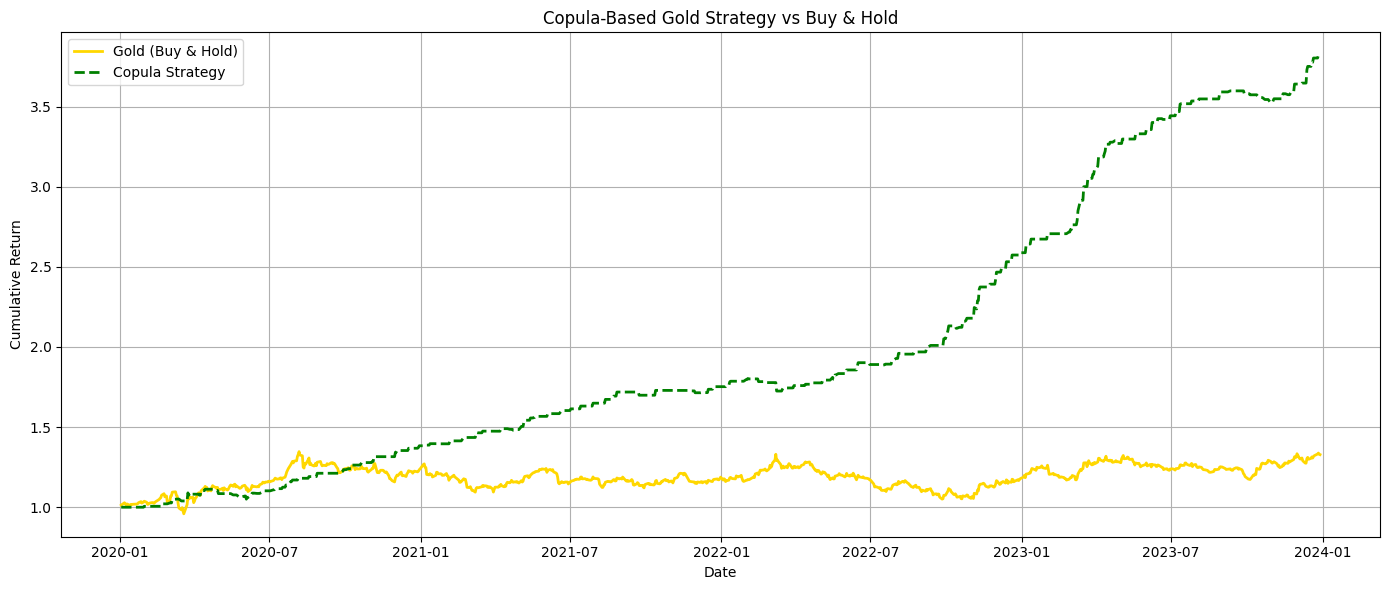

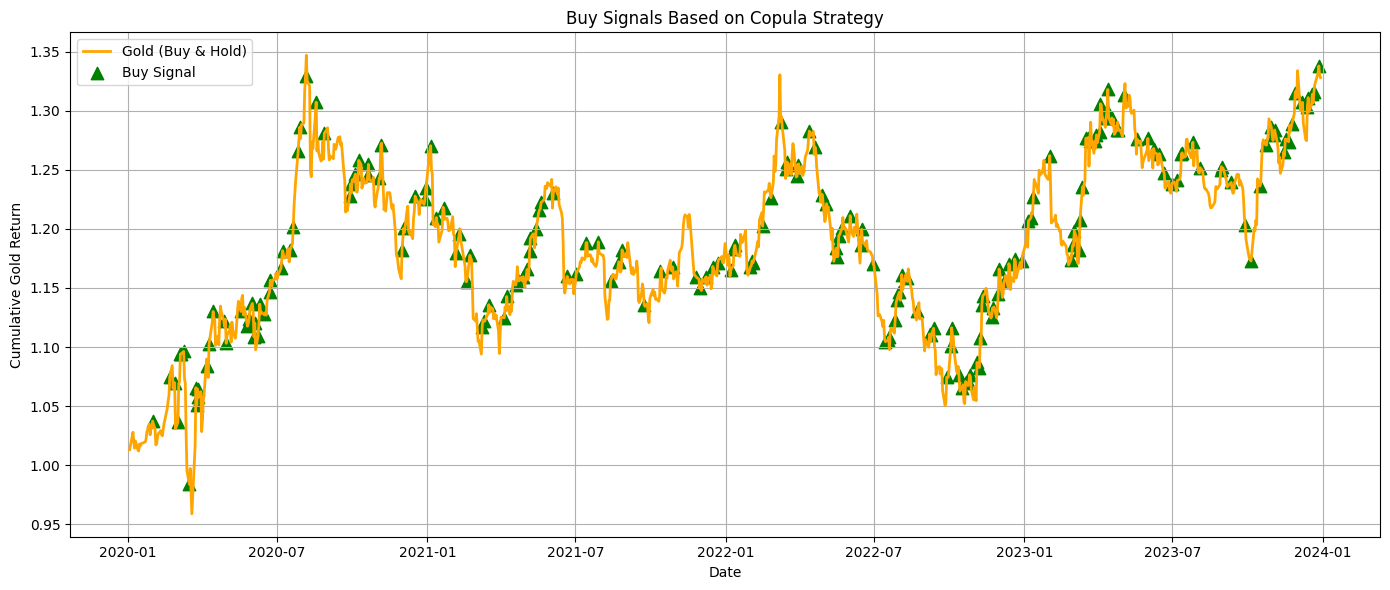

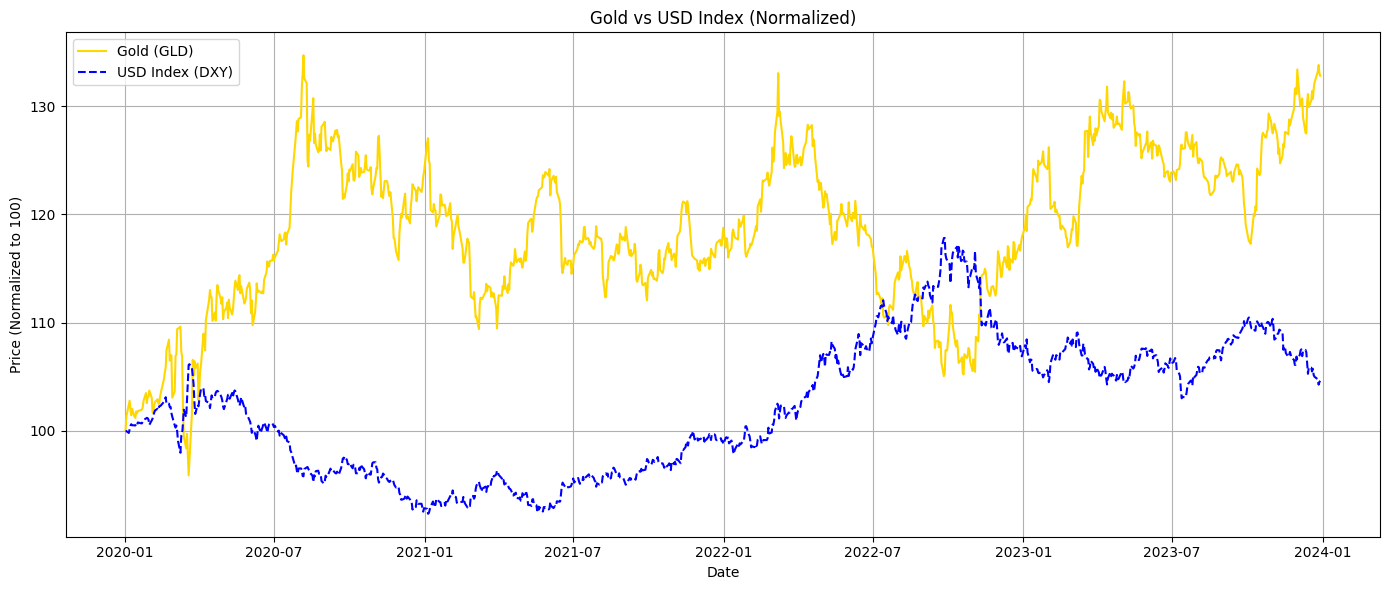

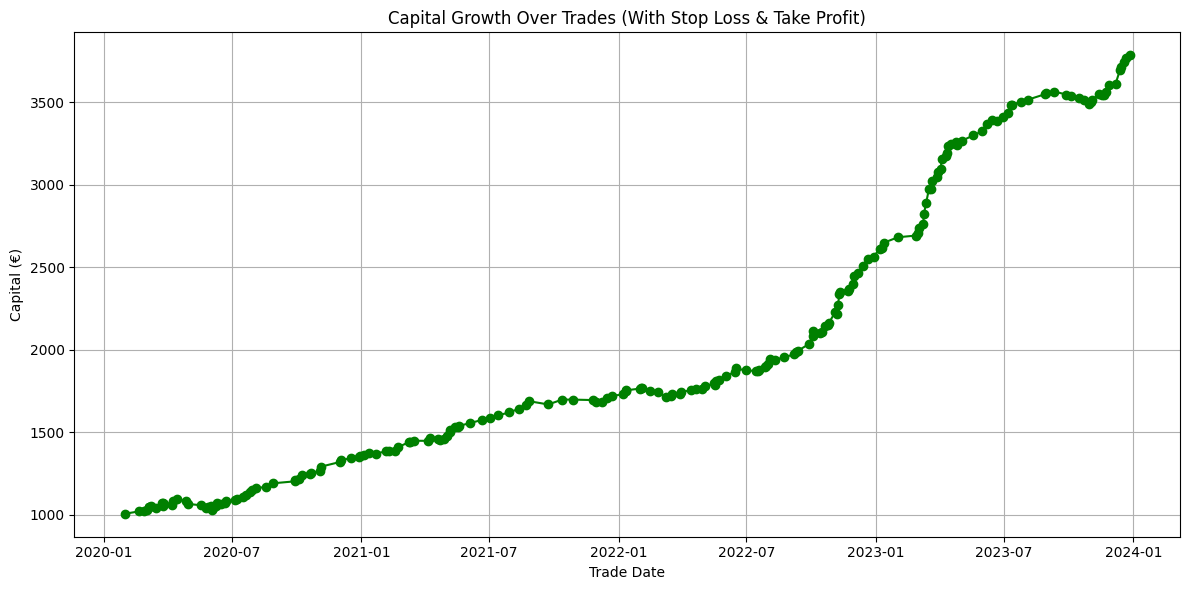

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copulas.multivariate import GaussianMultivariate

# --- PARAMETERS ---
initial_capital = 1000       # Starting capital in Euros
stop_loss = -0.02            # -2% stop loss
take_profit = 0.03           # +3% take profit

# --- STEP 1: Download Data ---
gold_data = yf.download('GLD', start='2020-01-01', end='2024-01-01')
usd_data = yf.download('DX-Y.NYB', start='2020-01-01', end='2024-01-01')

# --- STEP 2: Compute Daily Returns ---
gold_ret = gold_data['Close'].pct_change()
usd_ret = usd_data['Close'].pct_change()
data = pd.concat([gold_ret, usd_ret], axis=1)
data.columns = ['gold', 'usd']
data.dropna(inplace=True)

# --- STEP 3: Fit Copula ---
copula = GaussianMultivariate()
copula.fit(data)

# --- STEP 4: Generate Synthetic Joint Samples ---
samples = copula.sample(5000)

# --- STEP 5: Strategy Logic - Generate Signals ---
usd_thresh = data['usd'].quantile(0.2)
signals = []

for idx, row in data.iterrows():
    if row['usd'] < usd_thresh:
        similar_samples = samples[samples['usd'] < usd_thresh]
        prob_gold_up = (similar_samples['gold'] > 0).mean()
        signal = 1 if prob_gold_up > 0.6 else 0
    else:
        signal = 0
    signals.append(signal)

data['signal'] = signals

# --- STEP 6: Strategy Returns and Cumulative Returns ---
data['strategy_return'] = data['signal'] * data['gold']
data['gold_cum'] = (1 + data['gold']).cumprod()
data['strategy_cum'] = (1 + data['strategy_return']).cumprod()

# --- STEP 7: Filter Buy Signals ---
buy_signals = data[data['signal'] == 1].copy()

# --- STEP 8: Apply Stop Loss / Take Profit to Returns ---
adjusted_returns = []
for ret in buy_signals['gold']:
    if ret <= stop_loss:
        adjusted_returns.append(stop_loss)
    elif ret >= take_profit:
        adjusted_returns.append(take_profit)
    else:
        adjusted_returns.append(ret)

buy_signals['Adjusted Return'] = adjusted_returns

# --- STEP 9: Calculate Capital Progression (Compound Reinvestment) ---
capital = initial_capital
capital_history = []
for ret in adjusted_returns:
    capital = capital * (1 + ret)
    capital_history.append(capital)

buy_signals['Capital After Trade (€)'] = capital_history

# --- STEP 10: Prepare Output Table and Print (Until 2024) ---
output = buy_signals[['gold', 'Adjusted Return', 'Capital After Trade (€)']].copy()
output.columns = ['Actual Return', 'Adj Return (Stop/Take)', 'Capital After Trade (€)']
output.index.name = 'Date'

output_until_2024 = output.loc[output.index < '2024-01-01']

print("\nTrade Returns & Capital Progression (Up to 2024):\n")
print(output_until_2024.round(4))  # Rounded for neatness

# --- PLOTS ---

# 1) Copula Strategy vs Buy & Hold Gold
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['gold_cum'], label='Gold (Buy & Hold)', color='gold', linewidth=2)
plt.plot(data.index, data['strategy_cum'], label='Copula Strategy', color='green', linestyle='--', linewidth=2)
plt.title('Copula-Based Gold Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Buy Signals on Gold Cumulative Return
buy_dates = buy_signals.index
buy_prices = data.loc[buy_dates, 'gold_cum']

plt.figure(figsize=(14, 6))
plt.plot(data.index, data['gold_cum'], label='Gold (Buy & Hold)', color='orange', linewidth=2)
plt.scatter(buy_dates, buy_prices, color='green', label='Buy Signal', marker='^', s=80)
plt.title('Buy Signals Based on Copula Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Gold Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Gold vs USD Index (Normalized to 100)
gold_norm = (gold_data['Close'] / gold_data['Close'].iloc[0]) * 100
usd_norm = (usd_data['Close'] / usd_data['Close'].iloc[0]) * 100

plt.figure(figsize=(14, 6))
plt.plot(gold_norm.index, gold_norm, label='Gold (GLD)', color='gold')
plt.plot(usd_norm.index, usd_norm, label='USD Index (DXY)', color='blue', linestyle='--')
plt.title('Gold vs USD Index (Normalized)')
plt.xlabel('Date')
plt.ylabel('Price (Normalized to 100)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4) Capital Growth Over Trades (With Stop Loss & Take Profit)
plt.figure(figsize=(12, 6))
plt.plot(output_until_2024.index, output_until_2024['Capital After Trade (€)'], marker='o', color='green')
plt.title('Capital Growth Over Trades (With Stop Loss & Take Profit)')
plt.xlabel('Trade Date')
plt.ylabel('Capital (€)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
# Allow pandas to print full dataframe without truncation
pd.set_option('display.max_rows', None)       # Show all rows
pd.set_option('display.max_columns', None)    # Show all columns
pd.set_option('display.width', None)          # No line wrapping
pd.set_option('display.max_colwidth', None)  # No column width limit

print(output_until_2024.round(4))


            Actual Return  Adj Return (Stop/Take)  Capital After Trade (€)
Date                                                                      
2020-01-31         0.0058                  0.0058                1005.7924
2020-02-21         0.0150                  0.0150                1020.9047
2020-02-27         0.0002                  0.0002                1021.1036
2020-03-02         0.0055                  0.0055                1026.7465
2020-03-05         0.0216                  0.0216                1048.9252
2020-03-06         0.0004                  0.0004                1049.3248
2020-03-09         0.0017                  0.0017                1051.0564
2020-03-16        -0.0114                 -0.0114                1039.0259
2020-03-24         0.0485                  0.0300                1070.1967
2020-03-25        -0.0137                 -0.0137                1055.5461
2020-03-26         0.0128                  0.0128                1069.0805
2020-03-27        -0.0065

In [6]:
import pandas as pd

# Parameters
initial_capital = 1000
stop_loss = -0.02
take_profit = 0.03
commission_per_trade = 0.001  # 0.1% commission per trade (typical broker fee)
slippage = 0.0005  # 0.05% slippage per trade

# Assuming 'buy_signals' dataframe from your code (filtered where signal == 1)

adjusted_returns_with_costs = []
for ret in buy_signals['gold']:
    # Apply stop loss / take profit limits
    if ret <= stop_loss:
        adj_ret = stop_loss
    elif ret >= take_profit:
        adj_ret = take_profit
    else:
        adj_ret = ret

    # Subtract commission and slippage cost from returns
    # Commission and slippage reduce your return by (commission + slippage)
    adj_ret = adj_ret - commission_per_trade - slippage
    adjusted_returns_with_costs.append(adj_ret)

buy_signals['Adj Return with Costs'] = adjusted_returns_with_costs

# Calculate capital with costs
capital = initial_capital
capital_history = []
for ret in adjusted_returns_with_costs:
    capital = capital * (1 + ret)
    capital_history.append(capital)

buy_signals['Capital After Trade (€)'] = capital_history

print(buy_signals[['gold', 'Adj Return with Costs', 'Capital After Trade (€)']].round(4))


              gold  Adj Return with Costs  Capital After Trade (€)
Date                                                              
2020-01-31  0.0058                 0.0043                1004.2924
2020-02-21  0.0150                 0.0135                1017.8757
2020-02-27  0.0002                -0.0013                1016.5472
2020-03-02  0.0055                 0.0040                1020.6401
2020-03-05  0.0216                 0.0201                1041.1559
2020-03-06  0.0004                -0.0011                1039.9909
2020-03-09  0.0017                 0.0002                1040.1471
2020-03-16 -0.0114                -0.0129                1026.6812
2020-03-24  0.0485                 0.0285                1055.9416
2020-03-25 -0.0137                -0.0152                1039.9023
2020-03-26  0.0128                 0.0113                1051.6763
2020-03-27 -0.0065                -0.0080                1043.3044
2020-04-07 -0.0054                -0.0069                1036.